In [2]:
import h5py
import os
import pathlib as pl

path = pl.Path("..", "data", "embeddings.h5")  # adjust this path
if os.path.isfile(path):
    embeddings = h5py.File(path)

In [3]:
encoded_keys = list(embeddings.keys())

In [4]:
import sys
import tqdm
line_path = pl.Path("..", "data", "labels")  # adjust this path... it leads to the 3line files
line_path_names = os.listdir(line_path)

data = dict()
for file in tqdm.tqdm(line_path_names):
    file_path = pl.Path(line_path, file)

    label = []
    if "Glob" in file.split(".")[0]:
        label.append("G")
    if "SP" in file.split(".")[0]:
        label.append("SP")
    if "TM" in file.split(".")[0]:
        label.append("TM")

    label = "_".join(label)

    data[label] = dict()
    with open(file_path, "r") as f:
        prot_id = ""
        prot_seq = ""
        prot_annot = ""
        for line_index, line in enumerate(f, 0):
            line = line.strip()
            if line.startswith(">"):
                prot_id = line.replace(">", "")
                if "|" in line:
                    prot_id = prot_id.split("|")[0]
                data[label][prot_id] = list()
                continue

            data[label][prot_id].append(line)

100%|██████████| 4/4 [00:00<00:00, 150.05it/s]


In [5]:
import hashlib

all_generated_hashes = []
for label in data:
    for protein in data[label]:
        seq = data[label][protein][0].encode("UTF-8")
        hashed = hashlib.md5(seq).hexdigest()
        data[label][protein].append(hashed)
        all_generated_hashes.append(hashed)

In [17]:
encoded_keys

['0000349febc09c9ceee824616a5a1a28',
 '00005843e88e0893bd94af9d22cbaa58',
 '000122ad8c8fccfd2991bbd4a138d3c6',
 '0011ab0c11c7fea51fefcd039b1b69f5',
 '001df6914145e681a65b401d8bb5786e',
 '0022a6fb53681a7580a4d825014021f4',
 '0026dc4a3bfe07c8d2f0ebb94e113217',
 '004a69a3a09fe8e4395363671d2d8ee4',
 '00530f39a4e38c157efe7f85d5138759',
 '00656176bf43852ef189a234992d156d',
 '0067032e158218d341242a339353219b',
 '00a2e230767a7aebb667ea11577dad4b',
 '00ae598788e17bc4161b5349d10c97a6',
 '00afcde800026581661b6cbe2d08c898',
 '00bb1880bc3502e52b9aab144215eb8c',
 '00cd0dcef96b89b1580ab211c4f70caa',
 '00e47b382f81d456ce3309a23feeed81',
 '00efb90b2ab17d4c6fa921f6b226b7c3',
 '00f22487eb60954b8dad92cd97b20bb0',
 '010f63e81bfbde1299baffea3f5801e7',
 '0112668b0139b055b186a4313c48b1fb',
 '0120a56b735f7f7940c0837a4352ae89',
 '01258ad3a5379b23139798cdf552ac9c',
 '01280a52d8001033b76143e3e807cb58',
 '012e9d00373a3e971ba035b39a976267',
 '012ffb74f09a404ec295b6fb04217a48',
 '01318bf2c01aa738f0c105a652f8a966',
 

In [6]:
len(all_generated_hashes)
len(encoded_keys)

print(len(set(all_generated_hashes) - set(encoded_keys)))  # 0
print(len(set(encoded_keys) - set(all_generated_hashes)))  # 0

0
0


In [ ]:
import pickle

path = pl.Path("..", "data", 'seq_anno_hash.pickle')
with open(path, 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Structure

In [13]:
print(data.keys())
print(list(data["G"].keys())[:10], " ...")
print(len(data["G"]["P38448"]))

dict_keys(['G_SP', 'G', 'SP_TM', 'TM'])
['P38448', 'Q00594', 'P27888', 'P0CL03', 'P15034', 'P09961', 'P14898', 'Q9X758', 'Q7VAL5', 'P07642']  ...
3


In [15]:
data.keys()

dict_keys(['G_SP', 'G', 'SP_TM', 'TM'])

In [39]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
from itertools import chain

In [59]:
label_prot = [list(map(lambda x:[x, key], list(data[key].keys()))) for key in data]
label_prot = list(chain.from_iterable(label_prot))

In [63]:
label_prot_df = pd.DataFrame(label_prot, columns=["PROTS", "LABELS"])

In [78]:
X_train, X_test, y_train, y_test = train_test_split(label_prot_df["PROTS"], label_prot_df["LABELS"], test_size=0.2, train_size=0.8, stratify=label_prot_df["LABELS"], random_state=42)

<BarContainer object of 4 artists>

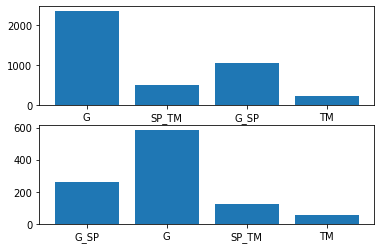

In [92]:
import matplotlib.pyplot as plt
from collections import Counter

train_dist = dict(Counter(y_train))
test_dist = dict(Counter(y_test))

fig, axs = plt.subplots(2, 1)
axs[0].bar(train_dist.keys(), train_dist.values())
axs[1].bar(test_dist.keys(), test_dist.values())